In [24]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from hyperopt import hp, fmin, tpe, Trials, space_eval, STATUS_OK
from data_process.data_transform_processor import DataTransformProcessor
from data_process.feature_engineer import FeatureEngineer
from models.model_flow import ModelFlow
from models.nn_models.dnn import DNN
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.linear_model import ElasticNet
from models.tree_models.lgbm import LGBM
from models.backtest import BackTest
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
df_properties = pd.read_csv('/Users/shuyangdu/Desktop/ZillowChallenge/data/raw_data/properties_2016.csv')

/Users/shuyangdu/anaconda/envs/py27/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df_properties = FeatureEngineer.rename(df_properties)

# Add features for properties

In [4]:
df_properties_engineered = FeatureEngineer.add_features_properties(df_properties)

In [5]:
df_properties_engineered.columns.shape

(99,)

# Add filled missing values

In [8]:
for region in ['zip', 'city', 'neighbor', 'county']:
    df_fill = pd.read_csv('/Users/shuyangdu/Desktop/ZillowChallenge/data/properties_fill_region_{}.csv'.format(region))
    df_properties_engineered['region_{}_filled'.format(region)] = df_fill['region_{}'.format(region)]

In [13]:
df_properties_engineered = FeatureEngineer.fill_missing_value(df_properties_engineered)

In [14]:
for col in df_properties_engineered:
    print col, df_properties_engineered[col].isnull().sum() / float(len(df_properties_engineered))

id_parcel 0.0
aircon 0.72815410069
architectural_style 0.997969661837
area_basement 0.999454646011
num_bathroom 0.0038395868709
num_bedroom 0.00383556706263
framing 0.995769486774
quality 0.350637491345
num_bathroom_calc 0.0431834603649
deck 0.994273113144
area_firstfloor_finished 0.932093043822
area_total_finished_calc 0.0186133872345
area_live_finished 0.0924666448034
area_liveperi_finished 0.997430002576
area_total_finished 0.936085718392
area_live_entry_finished 0.932093043822
area_basic 0.992630016511
fips 0.00383121227033
num_fireplace 0.895271600021
num_bathroom_full 0.0431834603649
num_garage 0.704119667012
area_garage 0.704119667012
flag_tub 0.976881412641
heating 0.394884525983
latitude 0.00383121227033
longitude 0.00383121227033
area_lot 0.0924887537489
num_pool 0.826634378673
area_pool 0.0
flag_hot_tub 0.987626025177
flag_spa 0.989255387464
flag_no_tub_or_spa 0.837378991209
zoning_landuse_county 0.0041125988496
zoning_landuse 0.00383121227033
zoning_property 0.33719089768
c

In [15]:
save_path='/Users/shuyangdu/Desktop/ZillowChallenge/data/properties_2016_engineered_20170923.csv'

In [16]:
df_properties_engineered.to_csv(save_path, index=False)

# Merge with transactions and further feature engineering

In [17]:
df_train = pd.read_csv('/Users/shuyangdu/Desktop/ZillowChallenge/data/raw_data/train_2016_v2.csv')

In [25]:
df_merged = FeatureEngineer.merge(df_properties_engineered, df_train)

In [26]:
df_merged.shape

(90275, 105)

In [27]:
df_merged = FeatureEngineer.add_features_transactions(df_merged)

In [28]:
df_merged.shape

(90275, 107)

In [49]:
df_merged.to_csv('/Users/shuyangdu/Desktop/ZillowChallenge/data/df_merged_20170923.csv', index=False)

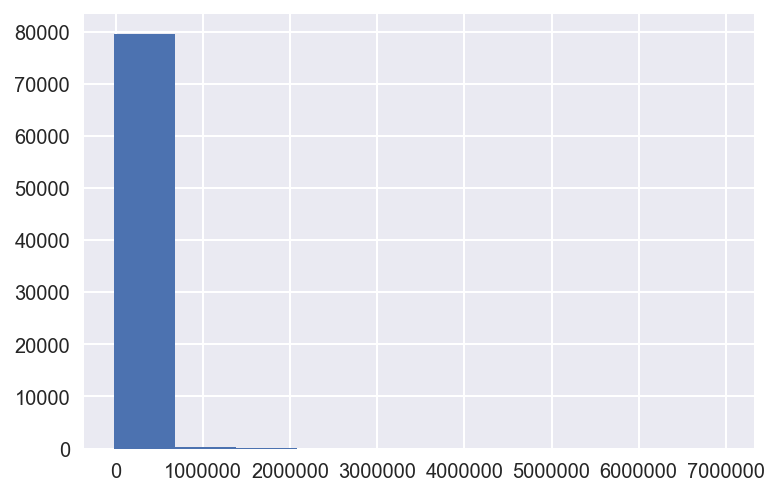

In [54]:
df_merged['area_extra'].hist()

/Users/shuyangdu/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':
/Users/shuyangdu/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in log
  if __name__ == '__main__':


ValueError: range parameter must be finite.

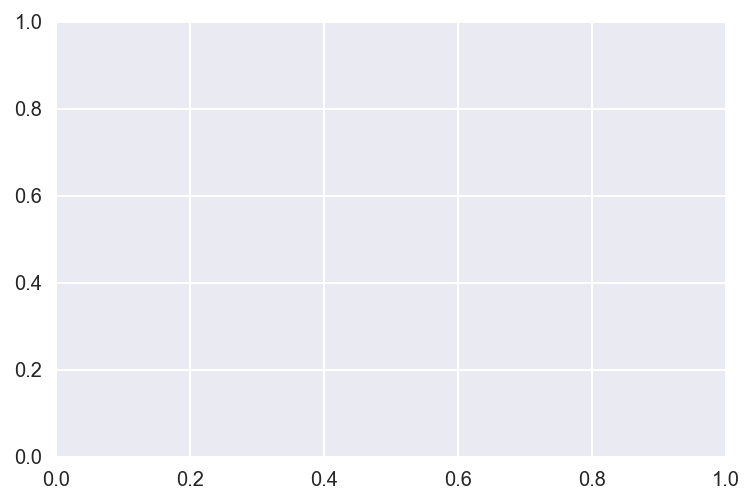

In [56]:
np.log(1 + df_merged['area_extra']).hist()

# ----Computation Heavy----

# Model based fill missing values

In [4]:
y_col = 'region_zip'
X_numerical_cols = ['latitude', 'longitude']
X_categorical_cols = ['region_neighbor', 'region_county', 'region_city']

In [5]:
data_transform_processor = DataTransformProcessor(
    numerical_cols=X_numerical_cols, 
    categorical_cols=X_categorical_cols,
    log_cols=[]
)

In [6]:
idx_train = df_properties[y_col].notnull().values

In [7]:
X_all = data_transform_processor.pre_process(df_properties)

In [8]:
y_all = df_properties[y_col].values

In [9]:
params = {
    'max_bin': 80,
    'learning_rate': 0.0216,
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'num_class': len(np.unique(y_all[idx_train])),
    'feature_fraction': 0.94,
    'bagging_fraction': 0.85,
    'bagging_freq': 80,
    'num_leaves': 60,
    'n_estimators': 200,
}

In [10]:
model = LGBM(is_classifier=True, categorical_feature=data_transform_processor.categorical_col_idx, **params)

In [11]:
X_train = data_transform_processor.fit_transform(X_all[idx_train])
y_train = y_all[idx_train]

In [14]:
%%time
model.fit(X_train, y_train)

CPU times: user 1d 7h 50min 1s, sys: 8h 50min 9s, total: 1d 16h 40min 11s
Wall time: 8h 36min 5s


In [15]:
X_pred = data_transform_processor.transform(X_all[~idx_train])

In [16]:
%%time
y_pred = model.predict(X_pred)

CPU times: user 13min 48s, sys: 9.69 s, total: 13min 58s
Wall time: 2min 3s


In [17]:
y_all[~idx_train] = y_pred

In [18]:
df_region = pd.DataFrame(y_all, columns=[y_col])

In [19]:
df_region.to_csv(
    '/Users/shuyangdu/Desktop/ZillowChallenge/data/properties_fill_{}.csv'.format(y_col), 
    index=False
)